### Decision Tree Classification: CART(Classification & Regression Tree)

In [1]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from skompiler import skompile
import graphviz

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [2]:
################################################
# 3. Modeling using CART
################################################

df = pd.read_csv("C:\\Users\\Monster\\Desktop\\Miuul\\Makine Öğrenmesi\\Kurs Materyalleri(Makine Öğrenmesi)\\datasets\\diabetes.csv")

In [3]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [4]:
cart_model = DecisionTreeClassifier(random_state=1).fit(X, y)

In [5]:
# Confusion matrix için y_pred: bütün gözlemler için tahmin edilen değerler
y_pred = cart_model.predict(X)

In [6]:
# AUC için y_prob:
y_prob = cart_model.predict_proba(X)[:, 1]

In [7]:
# Confusion matrix
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       268

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



In [8]:
# AUC
roc_auc_score(y, y_prob)

1.0

- Accuracy ve AUC değerleri 1 geldi yani doğruluk oranı %100 gibi duruyor ancak bu teorik olarak mümkün olmadığından başarı değerlendirme yöntemleri ile durumu analiz edelim.

In [9]:
#####################
# Holdout Yöntemi ile Başarı Değerlendirme
#####################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=45)

# holdout yöntemi için veri setini train test olarak ayırdık, modeli train seti ile kuruyoruz
cart_model = DecisionTreeClassifier(random_state=17).fit(X_train, y_train)

# Train Hatası, train veri seti için elde ettiğimiz hata
y_pred = cart_model.predict(X_train)
y_prob = cart_model.predict_proba(X_train)[:, 1]
print(classification_report(y_train, y_pred))
roc_auc_score(y_train, y_prob)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       191

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537



1.0

In [10]:
# Test Hatası, test veri seti için elde ettiğimiz hatayı hesaplayalım
y_pred = cart_model.predict(X_test)
y_prob = cart_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_prob)

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       154
           1       0.53      0.56      0.54        77

    accuracy                           0.69       231
   macro avg       0.65      0.66      0.65       231
weighted avg       0.69      0.69      0.69       231



0.6558441558441559

- Model train setinde(eğitildiği veri setinde) %100 doğruluk değeri verirken, test setinde %69, %65 gibi değerler geldi. Yani train ile test seti skorları arasında ciddi bir fark var.
- **Bu da modelin overfit olduğunu gösteriyor.** Yani model eğitildiği veri setini ezberlemeye başlamış, hiç görmediği eğitim veri setiyle karşılaşınca da pek kaydadeğer bir performans sergilemedi.

In [11]:
#####################
# CV(Cross-Validation) ile Başarı Değerlendirme
#####################

cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)

cv_results = cross_validate(cart_model,
                            X, y,
                            cv=5, # 5 katlı croos-validation
                            scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.7058568882098294

In [12]:
cv_results['test_f1'].mean()

0.5710621194523633

In [13]:
cv_results['test_roc_auc'].mean()

0.6719440950384347

- Cross-validation ile daha güvenilir sonuçlar elde ettik.
- Ancak şimdi de doğruluk değerlerimiz düşük. Bu değerleri artırmak için neler yapabiliriz?
- Yeni gözlemler, değişkenler eklenebilir, detaylı veri önişleme gerçekleştirilebilir, hiperparametre optimizasyonu yapılabilir.
- Ek olarak dengesiz veri yaklaşımları da ,özellikle bu problem için, tercih edilebilir.

In [14]:
################################################
# 4. Hyperparameter Optimization with GridSearchCV
################################################

# mevcut modelin hiperparametreleri nelerdir onlara bakalım
cart_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

- Burada CART ile ilgili ve overfit durumu için önemli 2 hiperparametre vardır:
  - max_depth
  - min_samples_split 'dir.

In [15]:
# bu değerleri önn tanımlı değerlere bakarak belirliyoruz
cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

In [16]:
cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=1).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [17]:
# bu iki hiperparametre için en iyi parametre değerleri
cart_best_grid.best_params_

{'max_depth': 5, 'min_samples_split': 4}

In [18]:
# en iyi parametrelere karşılık gelen skor yani en düşük hatayı veren 
cart_best_grid.best_score_

0.7500806383159324

In [19]:
random = X.sample(1, random_state=45)

In [20]:
random

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
195,5,158,84,41,210,39.4,0.395,29


In [21]:
cart_best_grid.predict(random)

array([1], dtype=int64)

In [22]:
################################################
# 5. Final Model
################################################

# daha önceden elde ettiğimiz, model için en iyi olan parametreleri kullanarak final modeli kuruyoruz
cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_, random_state=17).fit(X, y)
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [23]:
# en iyi parametreleri modele atamanın diğer yolu da budur, yeni bir model kurmak yerine
cart_final = cart_model.set_params(**cart_best_grid.best_params_).fit(X, y)

In [24]:
cv_results = cross_validate(cart_final,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.7500806383159324

In [25]:
cv_results['test_f1'].mean()

0.614625004082526

In [26]:
cv_results['test_roc_auc'].mean()

0.797796645702306

In [27]:
################################################
# 6. Feature Importance
################################################

# değişkenleri önem sıralarına göre(modele sağladığı katkıya göre) sıralamamız gerekiyor
cart_final.feature_importances_

array([0.01129738, 0.49448119, 0.05065617, 0.        , 0.01497644,
       0.22221379, 0.06819923, 0.13817579])

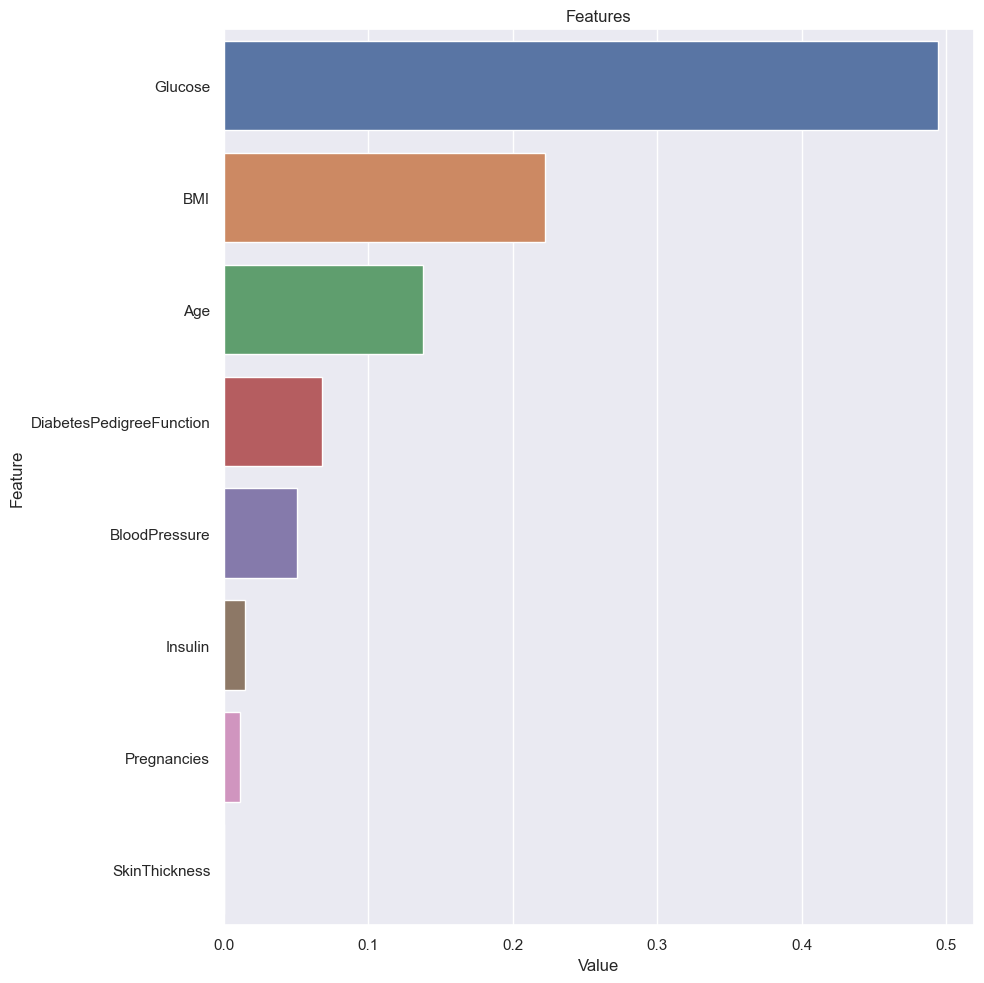

<Figure size 640x480 with 0 Axes>

In [28]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(cart_final, X, save=True)

In [29]:
################################################
# 7. Analyzing Model Complexity with Learning Curves (BONUS)
################################################


train_score, test_score = validation_curve(cart_final, X, y,
                                           param_name="max_depth",
                                           param_range=range(1, 11),
                                           scoring="roc_auc",
                                           cv=10)

In [30]:
train_score

array([[0.72320885, 0.72306132, 0.68555095, 0.72350392, 0.71698479,
        0.7011941 , 0.66131397, 0.71142923, 0.71549128, 0.71120294],
       [0.7987598 , 0.79874136, 0.76659751, 0.8000461 , 0.80217151,
        0.77901798, 0.76472568, 0.79175657, 0.80145087, 0.79440771],
       [0.84255417, 0.84810512, 0.82195943, 0.84559705, 0.8434532 ,
        0.81859843, 0.82218534, 0.83455048, 0.8413315 , 0.84593664],
       [0.8834947 , 0.88264638, 0.86355002, 0.88926233, 0.88226372,
        0.87104195, 0.86404334, 0.87285846, 0.87436639, 0.87684114],
       [0.91531581, 0.9138497 , 0.89976487, 0.92513601, 0.91451821,
        0.90380821, 0.88505302, 0.90792531, 0.91068411, 0.90586318],
       [0.94068234, 0.94559244, 0.92840479, 0.94609959, 0.94535731,
        0.9309728 , 0.91167819, 0.93286307, 0.94030303, 0.93088154],
       [0.96760258, 0.96744583, 0.95147533, 0.96842785, 0.96832181,
        0.95850161, 0.93983864, 0.96071   , 0.96145546, 0.95757576],
       [0.97867681, 0.98590595, 0.9736606

In [31]:
test_score

array([[0.64777778, 0.64925926, 0.68074074, 0.64481481, 0.64222222,
        0.68481481, 0.63666667, 0.75333333, 0.71692308, 0.75615385],
       [0.73407407, 0.74888889, 0.73555556, 0.71592593, 0.61703704,
        0.77777778, 0.70481481, 0.82555556, 0.74615385, 0.80038462],
       [0.78407407, 0.81333333, 0.77222222, 0.68296296, 0.69296296,
        0.82925926, 0.79259259, 0.85814815, 0.72615385, 0.80807692],
       [0.76481481, 0.81148148, 0.74962963, 0.60740741, 0.70888889,
        0.82111111, 0.83851852, 0.87333333, 0.77038462, 0.81961538],
       [0.73444444, 0.78666667, 0.76333333, 0.60037037, 0.71925926,
        0.84814815, 0.80074074, 0.88296296, 0.75730769, 0.81769231],
       [0.72814815, 0.77962963, 0.7462963 , 0.59481481, 0.76259259,
        0.82740741, 0.81592593, 0.83185185, 0.76038462, 0.77692308],
       [0.74222222, 0.77888889, 0.75222222, 0.54296296, 0.71851852,
        0.75444444, 0.82481481, 0.8462963 , 0.67346154, 0.76961538],
       [0.71481481, 0.7137037 , 0.7522222

In [32]:
mean_train_score = np.mean(train_score, axis=1)
mean_test_score = np.mean(test_score, axis=1)

print(f"Ortalama train skorları: {mean_train_score}")
print(f"Ortalama test skorları: {mean_test_score}")

Ortalama train skorları: [0.70729413 0.78976751 0.83642714 0.87603684 0.90819184 0.93528351
 0.96013549 0.97716774 0.98781586 0.99359846]
Ortalama test skorları: [0.68127066 0.74061681 0.77597863 0.77651852 0.77109259 0.76239744
 0.74034473 0.7137265  0.69966524 0.69232051]


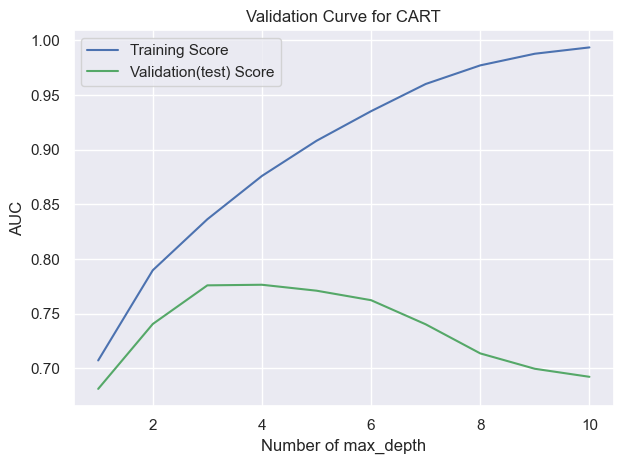

In [33]:
plt.plot(range(1, 11), mean_train_score,
         label="Training Score", color='b')

plt.plot(range(1, 11), mean_test_score,
         label="Validation(test) Score", color='g')

plt.title("Validation Curve for CART")
plt.xlabel("Number of max_depth")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

- Grafiği incelediğimizde max_depth 2 ile 4 arasındayken model overfit olmuş. Zaten daha önce yaptığımız işlemlerde en iyi parametrelerin kaç olduğunu bulmuştuk ve optimum max_depth 5 idi. 5'ten sonra train skorları ile validation skorları birbirinden bariz şekilde ayrışmaya başlıyor. Daha önceki işlem sonuçlarını grafik üzerinden de inceleyerek doğrulamış olduk.

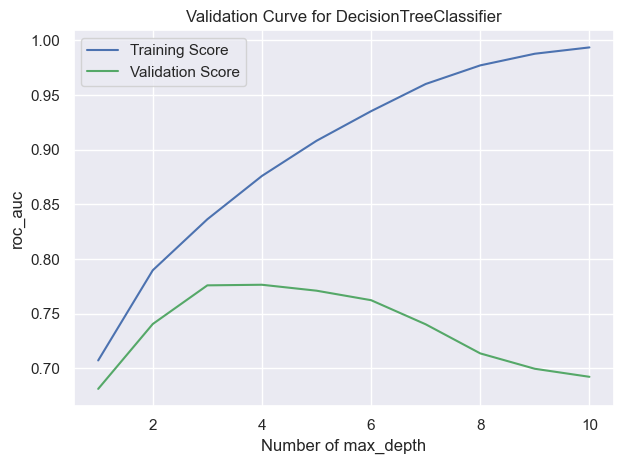

In [34]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}") # dinamik şekilde model isimlerini alır
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)


val_curve_params(cart_final, X, y, "max_depth", range(1, 11))

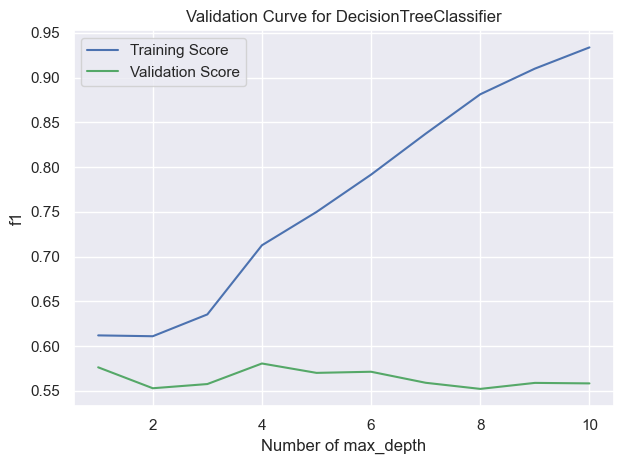

In [35]:
val_curve_params(cart_final, X, y, "max_depth", range(1, 11), scoring="f1")

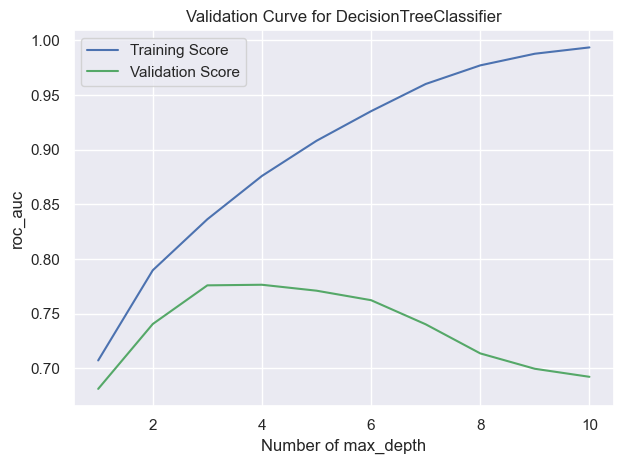

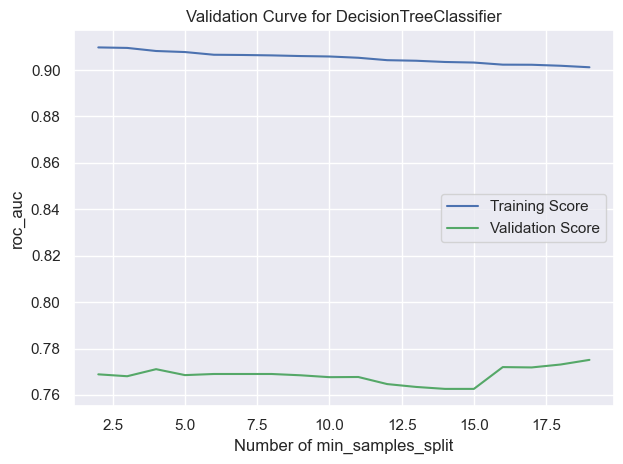

In [36]:
cart_val_params = [["max_depth", range(1, 11)], ["min_samples_split", range(2, 20)]]

for i in range(len(cart_val_params)):
    val_curve_params(cart_model, X, y, cart_val_params[i][0], cart_val_params[i][1])

In [37]:
################################################
# 8. Visualizing the Decision Tree
################################################

# conda install graphviz
# import graphviz

def tree_graph(model, col_names, file_name):
    tree_str = export_graphviz(model, feature_names=col_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(file_name)


# kurduğumuz modelin görsel çıktısını verecek
tree_graph(model=cart_final, col_names=X.columns, file_name="cart_final.png")

In [38]:
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [39]:
################################################
# 9. Extracting Decision Rules
################################################

tree_rules = export_text(cart_final, feature_names=list(X.columns))
print(tree_rules)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- BMI <= 30.95
|   |   |   |   |--- Pregnancies <= 7.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Pregnancies >  7.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- BMI >  30.95
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- BloodPressure <= 99.00
|   |   |   |   |--- class: 1
|   |   |   |--- BloodPressure >  99.00
|   |   |   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |   |--- BMI <= 9.65
|   |   |   |   |--- class: 1
|   |   |   |--- BMI >  9.65
|   |   |   |   |--- class: 0
|   |   |--- BMI >  26.35
|   |   |   |--- Glucose <= 99.50
|   |   |   |   |--- Glucose <= 28.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Glucose >  28.50
|   |   |   |   |   |--- class: 0
|   |  

In [40]:
################################################
# 10. Extracting Python Codes of Decision Rules
################################################

# sklearn '0.23.1' versiyonu ile yapılabilir.
# pip install scikit-learn==0.23.1

print(skompile(cart_final.predict).to('python/code')) # karar kurallarının Python kodu

(((((0 if x[0] <= 7.5 else 1) if x[5] <= 30.949999809265137 else 0 if x[6] <=
    0.5005000084638596 else 0) if x[5] <= 45.39999961853027 else 1 if x[2] <=
    99.0 else 0) if x[7] <= 28.5 else (1 if x[5] <= 9.649999618530273 else 
    0) if x[5] <= 26.350000381469727 else (1 if x[1] <= 28.5 else 0) if x[1
    ] <= 99.5 else 0 if x[6] <= 0.5609999895095825 else 1) if x[1] <= 127.5
     else (((0 if x[5] <= 28.149999618530273 else 1) if x[4] <= 132.5 else 
    0) if x[1] <= 145.5 else 0 if x[7] <= 25.5 else 1 if x[7] <= 61.0 else 
    0) if x[5] <= 29.949999809265137 else ((1 if x[2] <= 61.0 else 0) if x[
    7] <= 30.5 else 1 if x[6] <= 0.4294999986886978 else 1) if x[1] <= 
    157.5 else (1 if x[6] <= 0.3004999905824661 else 1) if x[4] <= 629.5 else 0
    )



In [ ]:
#print(skompile(cart_final.predict).to('sqlalchemy/sqlite')) # karar ağaçlarının sqlite kodları

In [49]:
print(skompile(cart_final.predict).to('excel'))

A1=IF((x2<=127.5),IF((x ...418 chars skipped... ((x5<=629.5),1,0))))


In [50]:
################################################
# 11. Prediction using Python Codes
################################################

def predict_with_rules(x):
    return ((((((0 if x[6] <= 0.671999990940094 else 1 if x[6] <= 0.6864999830722809 else
        0) if x[0] <= 7.5 else 1) if x[5] <= 30.949999809265137 else ((1 if x[5
        ] <= 32.45000076293945 else 1 if x[3] <= 10.5 else 0) if x[2] <= 53.0 else
        ((0 if x[1] <= 111.5 else 0 if x[2] <= 72.0 else 1 if x[3] <= 31.0 else
        0) if x[2] <= 82.5 else 1) if x[4] <= 36.5 else 0) if x[6] <=
        0.5005000084638596 else (0 if x[1] <= 88.5 else (((0 if x[0] <= 1.0 else
        1) if x[1] <= 98.5 else 1) if x[6] <= 0.9269999861717224 else 0) if x[1
        ] <= 116.0 else 0 if x[4] <= 166.0 else 1) if x[2] <= 69.0 else ((0 if
        x[2] <= 79.0 else 0 if x[1] <= 104.5 else 1) if x[3] <= 5.5 else 0) if
        x[6] <= 1.098000019788742 else 1) if x[5] <= 45.39999961853027 else 0 if
        x[7] <= 22.5 else 1) if x[7] <= 28.5 else (1 if x[5] <=
        9.649999618530273 else 0) if x[5] <= 26.350000381469727 else (1 if x[1] <=
        28.5 else ((0 if x[0] <= 11.5 else 1 if x[5] <= 31.25 else 0) if x[1] <=
        94.5 else (1 if x[5] <= 36.19999885559082 else 0) if x[1] <= 97.5 else
        0) if x[6] <= 0.7960000038146973 else 0 if x[0] <= 3.0 else (1 if x[6] <=
        0.9614999890327454 else 0) if x[3] <= 20.0 else 1) if x[1] <= 99.5 else
        ((1 if x[5] <= 27.649999618530273 else 0 if x[0] <= 5.5 else (((1 if x[
        0] <= 7.0 else 0) if x[1] <= 103.5 else 0) if x[1] <= 118.5 else 1) if
        x[0] <= 9.0 else 0) if x[6] <= 0.19999999552965164 else ((0 if x[5] <=
        36.14999961853027 else 1) if x[1] <= 113.0 else 1) if x[0] <= 1.5 else
        (1 if x[6] <= 0.3620000034570694 else 1 if x[5] <= 30.050000190734863 else
        0) if x[2] <= 67.0 else (((0 if x[6] <= 0.2524999976158142 else 1) if x
        [1] <= 120.0 else 1 if x[6] <= 0.23899999260902405 else 1 if x[7] <=
        30.5 else 0) if x[2] <= 83.0 else 0) if x[5] <= 34.45000076293945 else
        1 if x[1] <= 101.0 else 0 if x[5] <= 43.10000038146973 else 1) if x[6] <=
        0.5609999895095825 else ((0 if x[7] <= 34.5 else 1 if x[5] <=
        33.14999961853027 else 0) if x[4] <= 120.5 else (1 if x[3] <= 47.5 else
        0) if x[4] <= 225.0 else 0) if x[0] <= 6.5 else 1) if x[1] <= 127.5 else
        (((((1 if x[1] <= 129.5 else ((1 if x[6] <= 0.5444999933242798 else 0) if
        x[2] <= 56.0 else 0) if x[2] <= 71.0 else 1) if x[2] <= 73.0 else 0) if
        x[5] <= 28.149999618530273 else (1 if x[1] <= 135.0 else 0) if x[3] <=
        21.0 else 1) if x[4] <= 132.5 else 0) if x[1] <= 145.5 else 0 if x[7] <=
        25.5 else ((0 if x[1] <= 151.0 else 1) if x[5] <= 27.09999942779541 else
        ((1 if x[0] <= 6.5 else 0) if x[6] <= 0.3974999934434891 else 0) if x[2
        ] <= 82.0 else 0) if x[7] <= 61.0 else 0) if x[5] <= 29.949999809265137
         else ((1 if x[2] <= 61.0 else (((((0 if x[6] <= 0.18299999833106995 else
        1) if x[0] <= 0.5 else 1 if x[5] <= 32.45000076293945 else 0) if x[2] <=
        73.0 else 0) if x[0] <= 4.5 else 1 if x[6] <= 0.6169999837875366 else 0
        ) if x[6] <= 1.1414999961853027 else 1) if x[5] <= 41.79999923706055 else
        1 if x[6] <= 0.37299999594688416 else 1 if x[1] <= 142.5 else 0) if x[7
        ] <= 30.5 else (((1 if x[6] <= 0.13649999350309372 else 0 if x[5] <=
        32.45000076293945 else 1 if x[5] <= 33.05000114440918 else (0 if x[6] <=
        0.25599999725818634 else (0 if x[1] <= 130.5 else 1) if x[0] <= 8.5 else
        0) if x[0] <= 13.5 else 1) if x[2] <= 92.0 else 1) if x[5] <=
        45.54999923706055 else 1) if x[6] <= 0.4294999986886978 else (1 if x[5] <=
        40.05000114440918 else 0 if x[5] <= 40.89999961853027 else 1) if x[4] <=
        333.5 else 1 if x[2] <= 64.0 else 0) if x[1] <= 157.5 else ((((1 if x[7
        ] <= 25.5 else 0 if x[4] <= 87.5 else 1 if x[5] <= 45.60000038146973 else
        0) if x[7] <= 37.5 else 1 if x[7] <= 56.5 else 0 if x[6] <=
        0.22100000083446503 else 1) if x[6] <= 0.28849999606609344 else 0) if x
        [6] <= 0.3004999905824661 else 1 if x[7] <= 44.0 else (0 if x[7] <=
        51.0 else 1 if x[6] <= 1.1565000414848328 else 0) if x[0] <= 6.5 else 1
        ) if x[4] <= 629.5 else 1 if x[6] <= 0.4124999940395355 else 0)

X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [51]:
x = [12, 13, 20, 23, 4, 55, 12, 7]

predict_with_rules(x)

0

In [52]:
x = [6, 148, 70, 35, 0, 30, 0.62, 50]

predict_with_rules(x)

1

In [53]:
################################################
# 12. Saving and Loading Model
################################################


# oluşturduğumuz modeli kullanmak için her seferinde bu notebooku açmak yerine modeli kaydedip lazım olunca çağırıp kullanırız
joblib.dump(cart_final, "cart_final.pkl")

['cart_final.pkl']

In [54]:
cart_model_from_disc = joblib.load("cart_final.pkl") # sadece farklı bir isimlendirme yaptık

In [55]:
x = [12, 13, 20, 23, 4, 55, 12, 7]
cart_model_from_disc.predict(pd.DataFrame(x).T)

array([1], dtype=int64)